# Set Up Environment

In [ ]:
#@title Default title text

# Setup environment
!apt-get -qq install xxd
!pip install pandas numpy matplotlib
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Upload Data

1. Open the panel on the left side of Colab by clicking on the __>__
1. Select the files tab
1. Drag files from your computer to the tab to upload them into colab.

In [ ]:
tflite_model_name = 'hit_model'  # Will be given .tflite suffix
c_model_name = 'hit_model'       # Will be given .h suffix

# Graph Acceleration Data - not necessary

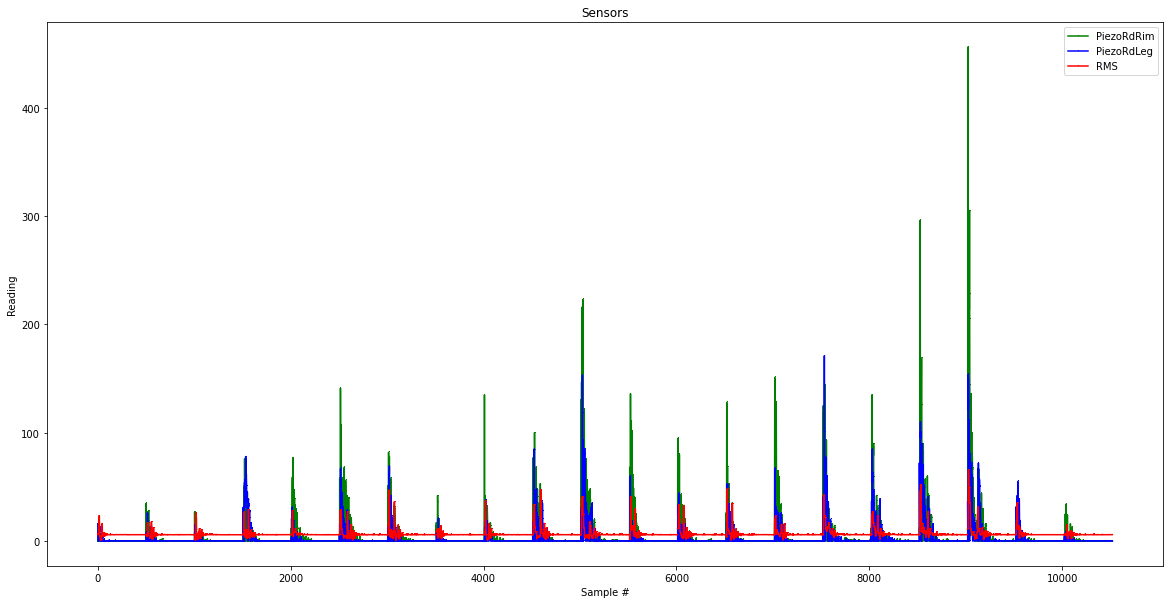

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

filename = "rim_shot.csv"

df = pd.read_csv("/content/" + filename)
index = range(1, len(df['PiezoRdRim']) + 1)



plt.rcParams["figure.figsize"] = (20,10)

plt.plot(index, df['PiezoRdRim'], 'g.', label='PiezoRdRim', linestyle='solid', marker=',')
plt.plot(index, df['PiezoRdLeg'], 'b.', label='PiezoRdLeg', linestyle='solid', marker=',')
plt.plot(index, df['RMS'], 'r.', label='RMS', linestyle='solid', marker=',')
plt.title("Sensors")
plt.xlabel("Sample #")
plt.ylabel("Reading")
plt.legend()
plt.show()

# Build and Train Neural Network
1. Parse and Prepare Data


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import random
import time
import math

print(f"TensorFlow version = {tf.__version__}\n")

# Set a fixed random seed value, for reproducibility, this will allow us to get
# the same random numbers each time the notebook is run
SEED = int(time.time())
np.random.seed(SEED)
tf.random.set_seed(SEED)

# the list of hit types that data is available for
HIT_TYPES = [
    "net_shot",
    "rim_shot",
]

SAMPLES_PER_HIT = 500

NUM_HIT_TYPES = len(HIT_TYPES)


# create a one-hot encoded matrix that is used in the output
ONE_HOT_ENCODED_HIT_TYPES = np.eye(NUM_HIT_TYPES)

inputs = []
outputs = []

# read each csv file and push an input and output
for hit_index in range(NUM_HIT_TYPES):
  hit_type = HIT_TYPES[hit_index]
  print(f"Processing index {hit_index} for hit type '{hit_type}'.")
  
  output = ONE_HOT_ENCODED_HIT_TYPES[hit_index]
  
  df = pd.read_csv("/content/" + hit_type + ".csv")
  
  # calculate the number of gesture recordings in the file
  num_recordings = int((df.shape[0]+1) / (SAMPLES_PER_HIT+1)) #added one for each blank line
  
  print(f"\tThere are {num_recordings} recordings of the {hit_type} hit type.")
  
  for i in range(num_recordings):  #added -1 so it wouldn't go out of range srt??
    tensor = []
    for j in range(500):
      index = i * (SAMPLES_PER_HIT+1) + j   #added +1 because there is a space between each sample

      #if first line of sample, make sure the previous line was blank
      if(j==0 and i>0 and not math.isnan(df['PiezoRdRim'][index-1])):
        print("\n\nERROR: INCORRECT SPACING\nLine", index, "\n\n\n")

      #make sure each input is a real number
      if(math.isnan(df['PiezoRdRim'][index]) or math.isnan(df['PiezoRdLeg'][index]) or math.isnan(df['RMS'][index])):
        print("\n\nERROR: NOT A NUMBER\n\n\n")

      # normalize the input data, between 0 to 1:
      # - acceleration is between: -4 to +4
      '''
      tensor.append([
          df['PiezoRdRim'][index],
          df['RMS'][index]
      ])
      '''
      tensor += [
          df['PiezoRdLeg'][index],
          df['RMS'][index],
      ]

    inputs.append(tensor)
    outputs.append(output)

# convert the list to numpy array
inputs = np.array(inputs)
outputs = np.array(outputs)

#print(inputs)

#inputs = inputs.astype(np.float32)
#outputs = outputs.astype(np.float32)


print("Data set parsing and preparation complete.")

TensorFlow version = 2.9.2

Processing index 0 for hit type 'net_shot'.
	There are 21 recordings of the net_shot hit type.
Processing index 1 for hit type 'rim_shot'.
	There are 21 recordings of the rim_shot hit type.
Data set parsing and preparation complete.


2. Randomize and Split Pairs for Training

In [ ]:
# Randomize the order of the inputs, so they can be evenly distributed for training, testing, and validation
# https://stackoverflow.com/a/37710486/2020087
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]

# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])


print("Data set randomization and splitting complete.")

Data set randomization and splitting complete.


3. Build and Train Model

In [ ]:
# build the model and train it
model = tf.keras.Sequential()
 # relu is used for performance
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dense(60, activation='relu'))
model.add(tf.keras.layers.Dense(20, activation='relu'))
model.add(tf.keras.layers.Dense(NUM_HIT_TYPES, activation='softmax')) # softmax is used, because we only expect one gesture to occur per input
#opt=tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9, nesterov=False, name="SGD")
opt=tf.keras.optimizers.Adam(learning_rate=0.0001)
#opt=tf.keras.optimizers.RMSprop(learning_rate=0.00001, momentum=0.99)
model.compile(optimizer=opt, loss='mse', metrics=['accuracy'])
history = model.fit(inputs_train, outputs_train, epochs=500, batch_size=30, validation_data=(inputs_validate, outputs_validate))

Epoch 1/500
1/1 [==============================] - 1s 503ms/step - loss: 0.4399 - accuracy: 0.5200 - val_loss: 0.4521 - val_accuracy: 0.5556
Epoch 2/500
1/1 [==============================] - 0s 37ms/step - loss: 0.3921 - accuracy: 0.5600 - val_loss: 0.4266 - val_accuracy: 0.5556
Epoch 3/500
1/1 [==============================] - 0s 29ms/step - loss: 0.3199 - accuracy: 0.6400 - val_loss: 0.3831 - val_accuracy: 0.4444
Epoch 4/500
1/1 [==============================] - 0s 33ms/step - loss: 0.2689 - accuracy: 0.7200 - val_loss: 0.3134 - val_accuracy: 0.4444
Epoch 5/500
1/1 [==============================] - 0s 28ms/step - loss: 0.2320 - accuracy: 0.7200 - val_loss: 0.2449 - val_accuracy: 0.5556
Epoch 6/500
1/1 [==============================] - 0s 29ms/step - loss: 0.1902 - accuracy: 0.7600 - val_loss: 0.1858 - val_accuracy: 0.7778
Epoch 7/500
1/1 [==============================] - 0s 48ms/step - loss: 0.1653 - accuracy: 0.8000 - val_loss: 0.1577 - val_accuracy: 0.7778
Epoch 8/500
1/1 [==

In [ ]:
# View model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 100)               100100    
                                                                 
 dense_5 (Dense)             (None, 60)                6060      
                                                                 
 dense_6 (Dense)             (None, 20)                1220      
                                                                 
 dense_7 (Dense)             (None, 2)                 42        
                                                                 
Total params: 107,422
Trainable params: 107,422
Non-trainable params: 0
_________________________________________________________________


# Verify

Graph Loss

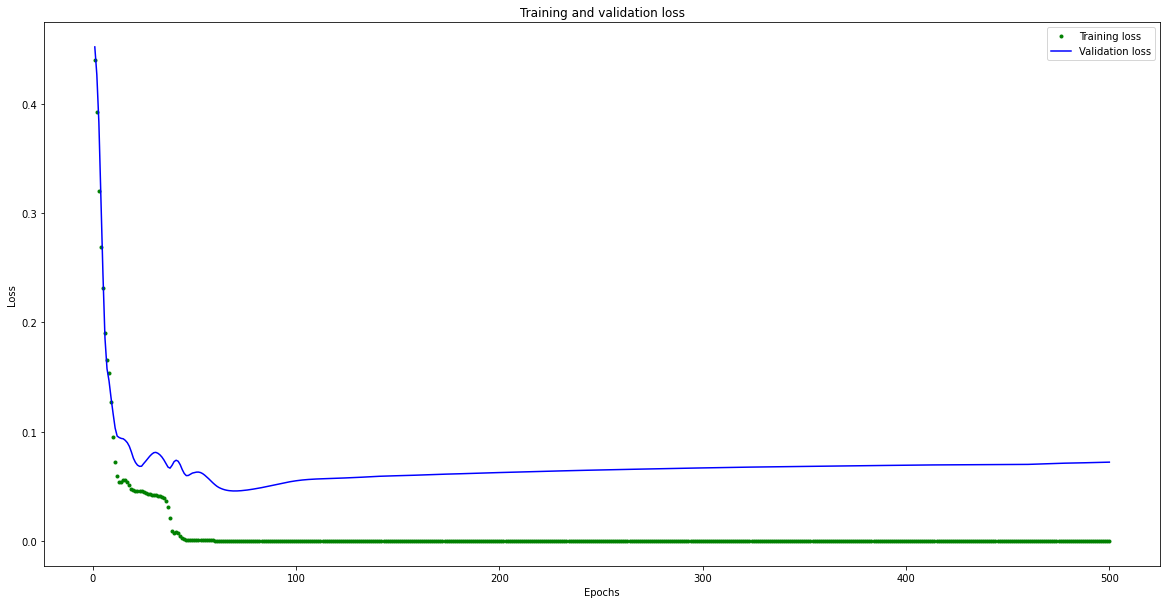

[20.0, 10.0]


In [ ]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (20,10)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

Graph Loss Skip Part of Beginning

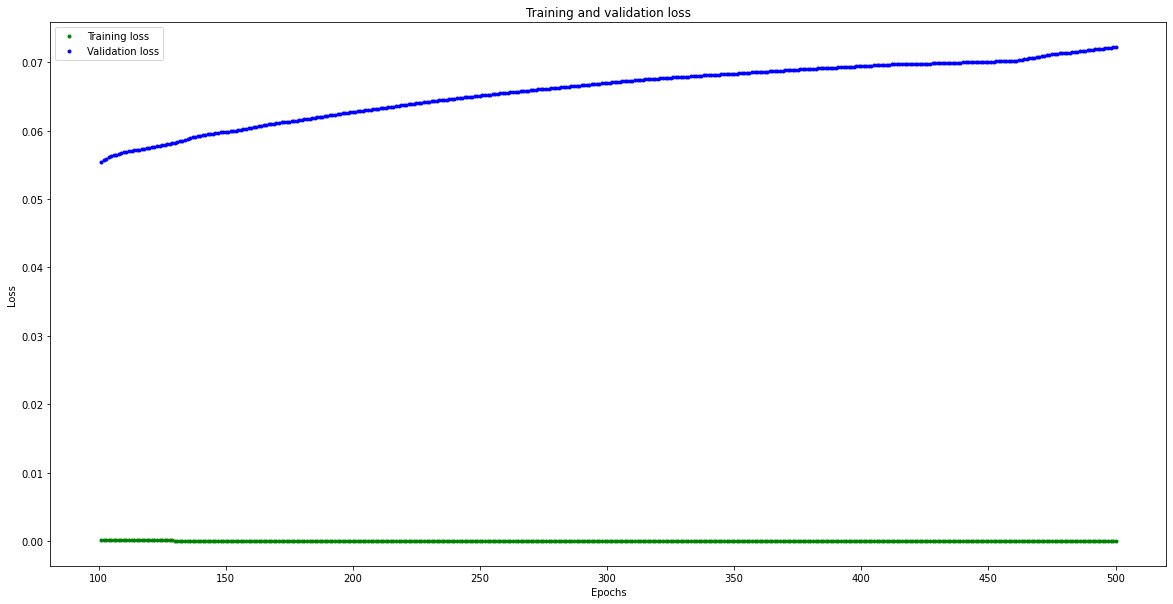

In [ ]:
# graph the loss again skipping a bit of the start
SKIP = 100
plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Graph MAE

In [ ]:
# graph of mean absolute error
mae = history.history['mae']
val_mae = history.history['val_mae']
plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

KeyError: ignored

Graph Accuracy

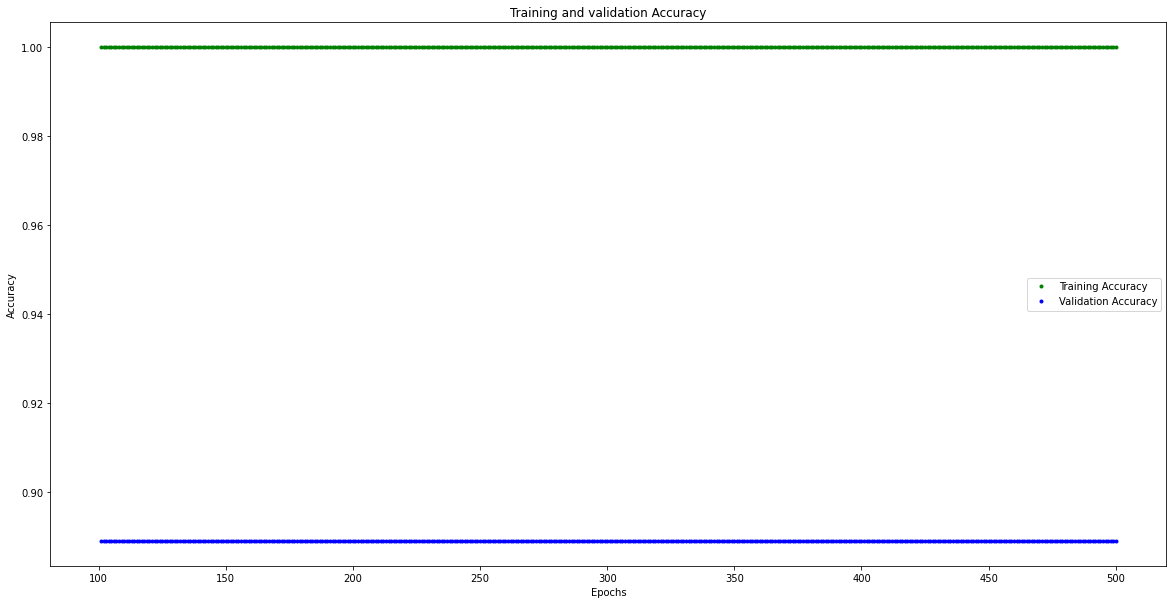

In [ ]:
# graph of accuracy
mae = history.history['accuracy']
val_mae = history.history['val_accuracy']
plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training Accuracy')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Run with Test Data

1/1 [==============================] - 0s 45ms/step
predictions =
 [[0.925 0.075]
 [0.084 0.916]
 [0.02  0.98 ]
 [0.795 0.205]
 [0.    1.   ]
 [1.    0.   ]
 [1.    0.   ]
 [1.    0.   ]]
actual =
 [[1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]
Correct Net:  4
Correct Rim:  3
Incorrect Net:  0
Incorrect Rim:  1
Correct Net: 4 / 4 = 100.0 %
Correct Rim: 3 / 4 = 75.0 %


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.


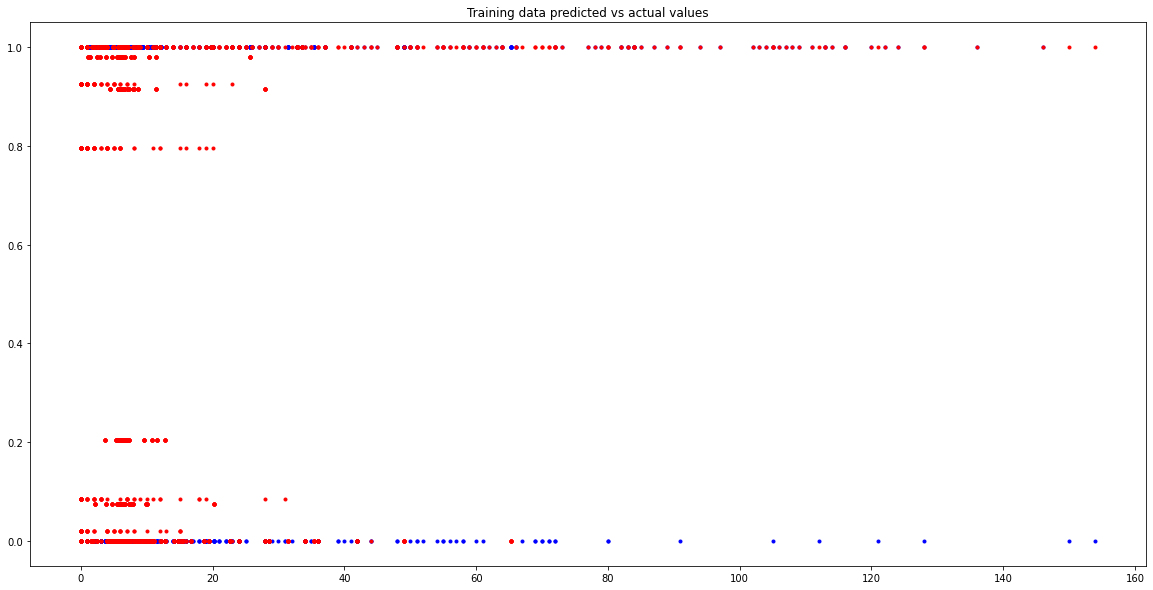

In [ ]:
# use the model to predict the test inputs
predictions = model.predict(inputs_test)

# print the predictions and the expected ouputs
print("predictions =\n", np.round(predictions, decimals=3))
print("actual =\n", outputs_test)

corr_rim = 0
corr_net = 0
incr_net = 0
incr_rim = 0

for i in range(len(predictions)):
  #actually was a net shot
  if outputs_test[i][0] == 1:
    #predicted net shot
    if predictions[i][0] > predictions[i][1]:
      corr_net += 1
    else:
      incr_net += 1
  #actually was a rim shot
  elif outputs_test[i][1] == 1:
    if predictions[i][0] < predictions[i][1]:
      corr_rim += 1
    else:
      incr_rim += 1

print("Correct Net: ", corr_net)
print("Correct Rim: ", corr_rim)
print("Incorrect Net: ", incr_net)
print("Incorrect Rim: ", incr_rim)
print(f"Correct Net: {corr_net} / {(corr_net + incr_net)} = {100*corr_net/(corr_net + incr_net)} %")
print(f"Correct Rim: {corr_rim} / {(corr_rim + incr_rim)} = {100*corr_rim/(corr_rim + incr_rim)} %")


# Plot the predictions along with to the test data
plt.clf()
plt.title('Training data predicted vs actual values')
plt.plot(inputs_test, outputs_test, 'b.', label='Actual')
plt.plot(inputs_test, predictions, 'r.', label='Predicted')
plt.show()

# Convert to tflite

In [ ]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("gesture_model.tflite", "wb").write(tflite_model)
  
import os
basic_model_size = os.path.getsize("gesture_model.tflite")
print("Model is %d bytes" % basic_model_size)
  

Model is 232204 bytes


#Convert to Arduino header file #

In [ ]:
!echo "const unsigned char model[] = {" > /content/model.h
!cat gesture_model.tflite | xxd -i      >> /content/model.h
!echo "};"                              >> /content/model.h

import os
model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Header file, model.h, is 1,431,960 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.
